# Approche avec BERT

In [15]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import clean_text

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit

In [13]:
%time
df_declaration_mrv = pd.read_csv("data/data_mrv/declaration_mrv_complet.csv")#delimiter=';',encoding='ISO-8859-1')
id_to_dco = pd.read_csv("data/ref_MRV/referentiel_dispositif.csv",delimiter=';',encoding='ISO-8859-1')
df_effets = pd.read_csv("data/ref_MRV/referentiel_dispositif_effets_connus.csv",delimiter=';',encoding='ISO-8859-1')
df_dys = pd.read_csv("data/ref_MRV/referentiel_dispositif_dysfonctionnement.csv",delimiter=';',encoding='ISO-8859-1')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 19.8 µs


In [66]:
%%time
#On complète les effets vide comme étant sans effets
df_declaration_mrv['TYPE_EFFET']  = df_declaration_mrv['TYPE_EFFET'].fillna("PAS D'EFFET NEFASTE DECLARE")
df_declaration_mrv['TEF_ID']= df_declaration_mrv['TEF_ID'].fillna('E1213')

#on selectionne les colonnes avec des effets
df = df_declaration_mrv[['DESCRIPTION_INCIDENT','TYPE_VIGILANCE','LIBELLE_COMMERCIAL',
                         'REFERENCE_COMMERCIALE','ETAT_PATIENT','FABRICANT','DCO_ID',
                         'ACTION_PATIENT','CLASSIFICATION','TEF_ID']]#[df_declaration_mrv['TEF_ID']!='E1213']
# On complète les NaN avec du vide
df['ETAT_PATIENT'] = df['ETAT_PATIENT'].fillna(" ")
df['DESCRIPTION_INCIDENT'] = df['DESCRIPTION_INCIDENT'].fillna(" ")
df['LIBELLE_COMMERCIAL'] = df['LIBELLE_COMMERCIAL'].fillna(" ")
df['FABRICANT'] = df['FABRICANT'].fillna(" ")
df["REFERENCE_COMMERCIALE"] = df['REFERENCE_COMMERCIALE'].fillna(" ")
df['TYPE_VIGILANCE'] = df['TYPE_VIGILANCE'].fillna(" ")
df['CLASSIFICATION'] = df['CLASSIFICATION'].fillna(' ')
df['DCO_ID'] = df['DCO_ID'].fillna(-1)
#On nettoieles variables textueelles : 

for col in  ['DESCRIPTION_INCIDENT','LIBELLE_COMMERCIAL','ETAT_PATIENT','FABRICANT','ACTION_PATIENT'] :
    df[col] = df[col].map(lambda x: clean_text.preprocess_text(x))


print(len(df))
n = 15
# On filtre pour a voir plus de n observations par classse
df = df.groupby("TEF_ID").filter(lambda x: len(x) > n)
print(len(df))
le_v = LabelEncoder()
df.TYPE_VIGILANCE = le_v.fit_transform(df.TYPE_VIGILANCE.values)
le = LabelEncoder()
df.TEF_ID = le.fit_transform(df.TEF_ID.values)

train_index,test_index = next(GroupShuffleSplit(random_state=1029).split(df, groups=df['DESCRIPTION_INCIDENT']))
df_train, df_test = df.iloc[train_index], df.iloc[test_index]
y = df_train.TEF_ID
y_test =df_test.TEF_ID

76954
76402
CPU times: user 22.4 s, sys: 272 ms, total: 22.7 s
Wall time: 22.7 s


In [67]:
features = ['DESCRIPTION_INCIDENT']
y_col = 'TEF_ID'

In [68]:
train_list = [elt[0] for elt in df_train[features].values.tolist()]
test_list =  [elt[0] for elt in df_test[features].values.tolist()]

In [84]:
train_list[6643]

'esthétique explantation le / / suite au souhait de la patiente de retirer les implants sein droit : rupture implant + coque stade sein gauche : rupture implant + coque stade rupture intracapsulaire signes appel clinique , à échographie , irm'

In [78]:
len(df_train[y_col].values)

61651

# using K train

In [4]:
import ktrain
from ktrain import text
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
import pandas as pd

In [71]:
text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face [https://arxiv.org/abs/1910.01108]


In [57]:
%time

mlb = MultiLabelBinarizer()

train = pd.read_pickle('./data_split/train.pkl')
# Pour faire un modèle sans le 
#train = train[~train['TEF_ID'].map(lambda x : 106 in x)]
X_train = train[['FABRICANT','CLASSIFICATION','DESCRIPTION_INCIDENT','ETAT_PATIENT','ACTION_PATIENT']]
y_train = mlb.fit_transform(train['TEF_ID'])
test =  pd.read_pickle('./data_split/test.pkl')
#test = test[~test['TEF_ID'].map(lambda x : k in x)]
X_test = test[['FABRICANT','CLASSIFICATION','DESCRIPTION_INCIDENT','ETAT_PATIENT','ACTION_PATIENT']]
y_test = mlb.transform(test['TEF_ID'])


df_effets = pd.read_csv("data/ref_MRV/referentiel_dispositif_effets_connus.csv",delimiter=';',encoding='ISO-8859-1')
df_dys = pd.read_csv("data/ref_MRV/referentiel_dispositif_dysfonctionnement.csv",delimiter=';',encoding='ISO-8859-1')


preprocess = ColumnTransformer(
    [('description_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=3,
                            ngram_range=(1, 1),
                            stop_words=STOP_WORDS,
                            max_features = 10000,norm = 'l2'), 'DESCRIPTION_INCIDENT'),
     
     ('etat_pat_tfidf', TfidfVectorizer(sublinear_tf=True, min_df=3,ngram_range=(1, 1),
                                       stop_words=STOP_WORDS,
                                       max_features = 10000,norm = 'l2'), 'ETAT_PATIENT'),
     
     ('fabricant_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=3,
                            ngram_range=(1, 1),
                            stop_words=STOP_WORDS,
                            max_features = 5000,norm = 'l2'), 'FABRICANT')
     ],
    
    remainder='passthrough')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 28.8 µs


NameError: name 'ColumnTransformer' is not defined

In [ ]:
# load an NBSVM model
model = text.text_classifier('nbsvm')


In [47]:
import ktrain
from ktrain import text
import joblib

encoder_TEF_ID = joblib.load('data_split/TEF_ID_encodeur.sav')

features = ['ACTION_PATIENT','DESCRIPTION_INCIDENT']
train_list = [elt[0] for elt in X_train[features].values.tolist()]
test_list =  [elt[0] for elt in X_test[features].values.tolist()]




trn, val, preproc = text.texts_from_array(x_train=train_list, y_train=y_train,
                                          x_test=test_list, y_test=y_test,
                                          class_names=encoder_TEF_ID.classes_.tolist(),
                                          preprocess_mode='standard',maxlen=350)


task: text classification
language: fr
Word Counts: 21168
Nrows: 26324
26324 train sequences
train sequence lengths:
	mean : 12
	95percentile : 39
	99percentile : 83
x_train shape: (26324,350)
y_train shape: (26324, 273)
Is Multi-Label? True
6580 test sequences
test sequence lengths:
	mean : 11
	95percentile : 37
	99percentile : 70
x_test shape: (6580,350)
y_test shape: (6580, 273)


Is Multi-Label? True
compiling word ID features...
maxlen is 350
done.
simulating training for different learning rates... this may take a few moments...
Train on 26324 samples
Epoch 1/1024
14630/26324 [===============>..............] - ETA: 15s - loss: 0.4183 - accuracy: 0.7455

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


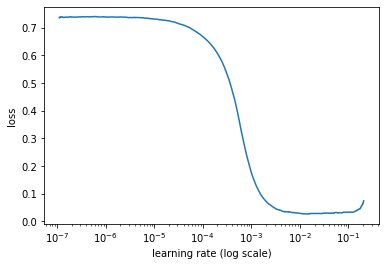

In [34]:
model = text.text_classifier('nbsvm', train_data=trn, preproc=preproc,multilabel =True)
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import Callback

class f1_Evaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            val=0.5
            y_pred[y_pred>=val]=1
            y_pred[y_pred<val]=0
            score = f1_score(self.y_val, y_pred,average='samples')
            print("\n f1 samples - epoch: %d - score: %.6f \n" % (epoch+1, score))
            
f1 = f1_Evaluation(validation_data=val, interval=1)


learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=10)
learner.lr_find()             # briefly simulate training to find good learning rate
learner.lr_plot()




In [35]:
learner.fit_onecycle(7e-4, 8,callbacks=[f1])



begin training using onecycle policy with max lr of 0.0007...
Train on 26324 samples, validate on 6580 samples
Epoch 1/8
26320/26324 [============================>.] - ETA: 0s - loss: 0.1412 - accuracy: 0.9524
 f1 samples - epoch: 1 - score: 0.461398 

26324/26324 [==============================] - 39s 1ms/sample - loss: 0.1411 - accuracy: 0.9524 - val_loss: 0.0215 - val_accuracy: 0.9953
Epoch 2/8
26320/26324 [============================>.] - ETA: 0s - loss: 0.0233 - accuracy: 0.9951
 f1 samples - epoch: 2 - score: 0.514995 

26324/26324 [==============================] - 40s 2ms/sample - loss: 0.0233 - accuracy: 0.9951 - val_loss: 0.0190 - val_accuracy: 0.9954
Epoch 3/8
26300/26324 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9954
 f1 samples - epoch: 3 - score: 0.491082 

26324/26324 [==============================] - 41s 2ms/sample - loss: 0.0202 - accuracy: 0.9954 - val_loss: 0.0171 - val_accuracy: 0.9957
Epoch 4/8
26290/26324 [========================

In [37]:
x_test = val[0].copy()
y_pred = learner.model.predict(x_test, verbose=0)
thresholds = [0.01,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7]
for val in thresholds:
    print("For threshold: ", val)
    pred=y_pred.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test, pred, average='samples')
    recall = recall_score(y_test, pred, average='samples')
    f1 = f1_score(y_test, pred, average='samples')
   
    print("Samples-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

For threshold:  0.01
Samples-average quality numbers
Precision: 0.1954, Recall: 0.8754, F1-measure: 0.2705
For threshold:  0.04
Samples-average quality numbers
Precision: 0.3799, Recall: 0.7673, F1-measure: 0.4568
For threshold:  0.06
Samples-average quality numbers
Precision: 0.4469, Recall: 0.7315, F1-measure: 0.5150
For threshold:  0.08
Samples-average quality numbers
Precision: 0.5361, Recall: 0.6958, F1-measure: 0.5754
For threshold:  0.1
Samples-average quality numbers
Precision: 0.5554, Recall: 0.6759, F1-measure: 0.5850
For threshold:  0.12


/home/user1/DGS-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Samples-average quality numbers
Precision: 0.5695, Recall: 0.6609, F1-measure: 0.5914
For threshold:  0.14
Samples-average quality numbers
Precision: 0.5777, Recall: 0.6483, F1-measure: 0.5941
For threshold:  0.16
Samples-average quality numbers
Precision: 0.5820, Recall: 0.6379, F1-measure: 0.5939
For threshold:  0.2
Samples-average quality numbers
Precision: 0.5847, Recall: 0.6235, F1-measure: 0.5912
For threshold:  0.25
Samples-average quality numbers
Precision: 0.5848, Recall: 0.6082, F1-measure: 0.5861
For threshold:  0.3
Samples-average quality numbers
Precision: 0.5811, Recall: 0.5942, F1-measure: 0.5791
For threshold:  0.35
Samples-average quality numbers
Precision: 0.5734, Recall: 0.5734, F1-measure: 0.5656
For threshold:  0.4
Samples-average quality numbers
Precision: 0.5635, Recall: 0.5582, F1-measure: 0.5538
For threshold:  0.5
Samples-average quality numbers
Precision: 0.5394, Recall: 0.5281, F1-measure: 0.5273
For threshold:  0.6
Samples-average quality numbers
Precision:

## fasttext model

task: text classification
language: vi
Word Counts: 40
Nrows: 26324
26324 train sequences
train sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1
x_train shape: (26324,350)
y_train shape: (26324, 273)
Is Multi-Label? True
6580 test sequences
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1
x_test shape: (6580,350)
y_test shape: (6580, 273)
Is Multi-Label? True
compiling word ID features...
maxlen is 350
done.
simulating training for different learning rates... this may take a few moments...
Train on 26324 samples
Epoch 1/1024
14680/26324 [===============>..............] - ETA: 17s - loss: 0.4087 - accuracy: 0.7492

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


begin training using onecycle policy with max lr of 0.001...
Train on 26324 samples, validate on 6580 samples
Epoch 1/5
26300/26324 [============================>.] - ETA: 0s - loss: 0.

/home/user1/DGS-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Samples-average quality numbers
Precision: 0.5418, Recall: 0.5397, F1-measure: 0.5404
For threshold:  0.6
Samples-average quality numbers
Precision: 0.1962, Recall: 0.1954, F1-measure: 0.1956


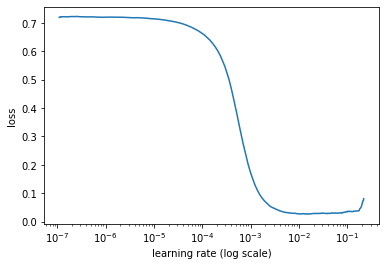

In [68]:
import ktrain
from ktrain import text
import joblib

encoder_TEF_ID = joblib.load('data_split/TEF_ID_encodeur.sav')

features = 'ACTION_PATIENT'
train_list = [elt[0] for elt in X_train[features].values.tolist()]
test_list =  [elt[0] for elt in X_test[features].values.tolist()]




trn, val, preproc = text.texts_from_array(x_train=train_list, y_train=y_train,
                                          x_test=test_list, y_test=y_test,
                                          class_names=encoder_TEF_ID.classes_.tolist(),
                                          preprocess_mode='standard',maxlen=350)


model = text.text_classifier('fasttext', train_data=trn, preproc=preproc,multilabel =True)
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import Callback

class f1_Evaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            val=0.5
            y_pred[y_pred>=val]=1
            y_pred[y_pred<val]=0
            score = f1_score(self.y_val, y_pred,average='samples')
            print("\n f1 samples - epoch: %d - score: %.6f \n" % (epoch+1, score))
            
f1 = f1_Evaluation(validation_data=val, interval=1)


learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=10)
learner.lr_find()             # briefly simulate training to find good learning rate
learner.lr_plot()


learner.fit_onecycle(1e-3, 5,callbacks=[f1])

from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score,f1_score,classification_report,recall_score,precision_score
y_pred = learner.model.predict(val[0], verbose=0)

thresholds = [0.01,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.2,0.25,0.3,0.35,0.4,0.5,0.6]
for val in thresholds:
    print("For threshold: ", val)
    pred=y_pred.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test, pred, average='samples')
    recall = recall_score(y_test, pred, average='samples')
    f1 = f1_score(y_test, pred, average='samples')
   
    print("Samples-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score,f1_score,classification_report,recall_score,precision_score


thresholds = [0.01,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.2,0.25,0.3,0.35,0.4,0.5,0.6]
for val in thresholds:
    print("For threshold: ", val)
    pred=y_pred.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test, pred, average='samples')
    recall = recall_score(y_test, pred, average='samples')
    f1 = f1_score(y_test, pred, average='samples')
   
    print("Samples-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

For threshold:  0.01
Samples-average quality numbers
Precision: 0.1775, Recall: 0.8780, F1-measure: 0.2669
For threshold:  0.04
Samples-average quality numbers
Precision: 0.3973, Recall: 0.7706, F1-measure: 0.4737
For threshold:  0.06
Samples-average quality numbers
Precision: 0.4562, Recall: 0.7418, F1-measure: 0.5235
For threshold:  0.08


/home/user1/DGS-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Samples-average quality numbers
Precision: 0.5005, Recall: 0.7144, F1-measure: 0.5546
For threshold:  0.1
Samples-average quality numbers
Precision: 0.5618, Recall: 0.6921, F1-measure: 0.5932
For threshold:  0.12
Samples-average quality numbers
Precision: 0.5728, Recall: 0.6769, F1-measure: 0.5980
For threshold:  0.14
Samples-average quality numbers
Precision: 0.5829, Recall: 0.6635, F1-measure: 0.6015
For threshold:  0.16
Samples-average quality numbers
Precision: 0.5902, Recall: 0.6536, F1-measure: 0.6034
For threshold:  0.2
Samples-average quality numbers
Precision: 0.5955, Recall: 0.6365, F1-measure: 0.6011
For threshold:  0.25
Samples-average quality numbers
Precision: 0.5931, Recall: 0.6199, F1-measure: 0.5945
For threshold:  0.3
Samples-average quality numbers
Precision: 0.5890, Recall: 0.6030, F1-measure: 0.5864
For threshold:  0.35
Samples-average quality numbers
Precision: 0.5794, Recall: 0.5854, F1-measure: 0.5745
For threshold:  0.4
Samples-average quality numbers
Precision

## Bi Gru

Is Multi-Label? True
compiling word ID features...
maxlen is 350
word vectors will be loaded from: https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz
processing pretrained word vectors...
loading pretrained word vectors...this may take a few moments...


done.
simulating training for different learning rates... this may take a few moments...
Train on 26324 samples
Epoch 1/1024
13940/26324 [==============>...............] - ETA: 11:40 - loss: 0.3274 - accuracy: 0.8378

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


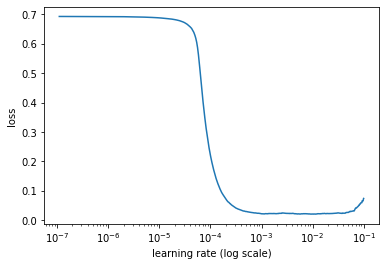

In [49]:
model = text.text_classifier('bigru', train_data=trn, preproc=preproc,multilabel =True)
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import Callback

class f1_Evaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            val=0.5
            y_pred[y_pred>=val]=1
            y_pred[y_pred<val]=0
            score = f1_score(self.y_val, y_pred,average='samples')
            print("\n f1 samples - epoch: %d - score: %.6f \n" % (epoch+1, score))
            
f1 = f1_Evaluation(validation_data=val, interval=1)


learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=10)
learner.lr_find()             # briefly simulate training to find good learning rate
learner.lr_plot()

In [50]:
learner.fit_onecycle(7e-5, 8,callbacks=[f1])



begin training using onecycle policy with max lr of 7e-05...
Train on 26324 samples, validate on 6580 samples
Epoch 1/8
26320/26324 [============================>.] - ETA: 0s - loss: 0.3226 - accuracy: 0.9401
 f1 samples - epoch: 1 - score: 0.550659 

26324/26324 [==============================] - 1530s 58ms/sample - loss: 0.3225 - accuracy: 0.9401 - val_loss: 0.0211 - val_accuracy: 0.9951
Epoch 2/8
26320/26324 [============================>.] - ETA: 0s - loss: 0.0203 - accuracy: 0.9951
 f1 samples - epoch: 2 - score: 0.550659 

26324/26324 [==============================] - 1817s 69ms/sample - loss: 0.0203 - accuracy: 0.9951 - val_loss: 0.0199 - val_accuracy: 0.9951
Epoch 3/8
26320/26324 [============================>.] - ETA: 0s - loss: 0.0199 - accuracy: 0.9951
 f1 samples - epoch: 3 - score: 0.550659 

26324/26324 [==============================] - 1881s 71ms/sample - loss: 0.0199 - accuracy: 0.9951 - val_loss: 0.0199 - val_accuracy: 0.9951
Epoch 4/8
 3290/26324 [==>.............

KeyboardInterrupt: 

In [51]:
x_test = val[0].copy()
y_pred = learner.model.predict(x_test, verbose=0)
thresholds = [0.01,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7]
for val in thresholds:
    print("For threshold: ", val)
    pred=y_pred.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test, pred, average='samples')
    recall = recall_score(y_test, pred, average='samples')
    f1 = f1_score(y_test, pred, average='samples')
   
    print("Samples-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

For threshold:  0.01
Samples-average quality numbers
Precision: 0.0478, Recall: 0.8159, F1-measure: 0.0862
For threshold:  0.04
Samples-average quality numbers
Precision: 0.1723, Recall: 0.6541, F1-measure: 0.2628
For threshold:  0.06
Samples-average quality numbers
Precision: 0.3357, Recall: 0.5768, F1-measure: 0.4089
For threshold:  0.08
Samples-average quality numbers
Precision: 0.5521, Recall: 0.5499, F1-measure: 0.5507
For threshold:  0.1
Samples-average quality numbers
Precision: 0.5521, Recall: 0.5499, F1-measure: 0.5507
For threshold:  0.12
Samples-average quality numbers
Precision: 0.5521, Recall: 0.5499, F1-measure: 0.5507
For threshold:  0.14
Samples-average quality numbers
Precision: 0.5521, Recall: 0.5499, F1-measure: 0.5507
For threshold:  0.16
Samples-average quality numbers
Precision: 0.5521, Recall: 0.5499, F1-measure: 0.5507
For threshold:  0.2
Samples-average quality numbers
Precision: 0.5521, Recall: 0.5499, F1-measure: 0.5507
For threshold:  0.25
Samples-average qu

/home/user1/DGS-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Samples-average quality numbers
Precision: 0.0000, Recall: 0.0000, F1-measure: 0.0000
For threshold:  0.7
Samples-average quality numbers
Precision: 0.0000, Recall: 0.0000, F1-measure: 0.0000


In [23]:
import transformers
from transformers import glue_convert_examples_to_features
from transformers import TFBertForSequenceClassification
import tensorflow as tf


In [26]:
from transformers import DistilBertTokenizer, RobertaTokenizer 

distil_bert = 'distilbert-base-uncased' # Pick any desired pre-trained model
roberta = 'roberta-base'

# Defining DistilBERT tokonizer
tokenizer = DistilBertTokenizer.from_pretrained(distil_bert, do_lower_case=True, add_special_tokens=True,
                                                max_length=128, pad_to_max_length=True)
# Defining RoBERTa tokinizer
tokenizer = RobertaTokenizer.from_pretrained(roberta, do_lower_case=True, add_special_tokens=True,
                                                max_length=128, pad_to_max_length=True)

In [8]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-cased")
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")


train_dataset = df_train[['DESCRIPTION_INCIDENT']]
train_dataset = glue_convert_examples_to_features(train_dataset, tokenizer, 128, 'mrpc')

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


AttributeError: 'str' object has no attribute 'decode'

In [ ]:
model.fit(train_dataset, epochs=3)

In [ ]:



# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5
# we will do just 1 epoch for illustration, though multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 1
# model initialization
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
# classifier Adam recommended
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])